Diabetes mellitus (DM) is a chronic disease which is identified by high blood sugar levels and associated with complications relating to both small and large blood vessels. DM comes in multiple types including prediabetes, gestational diabetes, and diabetes types I and II.  Over half a billion people worldwide are currently living with diabetes.  The International Diabetes Federation (IDF) projects this will rise to almost 800 million people by the middle of the century (IDF, 2023). Catching diabetes early means one can initiate both lifestyle and medicine interventions that can slow progression or even prevent the conversion into a full blown disease.  This in turn will reduce long-term healthcare costs, morbidity, and mortality (CDC, 2023).

In this project, I build a supervised-learning pipeline that predicts the probability an individual has pre-diabetes using self-reported health-survey variables from the 2015 CDC Behavioral Risk-Factor Surveillance System (BRFSS) “Diabetes 012 Health Indicators” dataset. The goal is to develop a well-calibrated, interpretable model that could be used as a public-health screening tool.

In [44]:
# 0. Optional one-time installs (leave commented in notebooks)
# !pip install pandas numpy matplotlib seaborn scikit-learn shap optuna
# !pip install xgboost optuna
# !pip install imbalanced-learn
# !pip install catboost

In [45]:
# 1. Imports
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

# data
import pandas as pd, numpy as np
pd.set_option("display.max_columns", None)       # show ALL columns
pd.set_option("display.width",        None)      # don’t wrap to terminal width

import matplotlib.pyplot as plt, seaborn as sns
plt.rcParams["figure.dpi"] = 110

# sklearn core
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix,
    ConfusionMatrixDisplay, brier_score_loss, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# imbalanced-learn
from imblearn.pipeline import Pipeline          
from imblearn.over_sampling import SMOTE

# advanced models and tuning
import shap, optuna, xgboost as xgb, catboost as cb

Imports all libraries centralised here for reproducibility. Key stacks: pandas for data, seaborn / matplotlib for EDA plots, scikit-learn for classical machine learning and metrics, imblearn for sampling, xgboost and catboost for gradient boosting, SHAP for explainability.

In [39]:
# 2. Configuration and Paths
DATA_URL      = "data/diabetes_012_health_indicators_BRFSS2015.csv"
RAW_TARGET    = "Diabetes_012"      # 0 / 1 / 2
TARGET        = "Diabetes_binary"   # new 0 / 1 column
TEST_SIZE     = 0.20
RANDOM_STATE  = 42

assert Path(DATA_URL).is_file(), f"Could not find {DATA_URL}"

Configuration defines data path, target engineering and random seed. Using Diabetes_012 to Diabetes_binary collapses pre-diabetes (1) and diabetes (2) into the positive class.

(253680, 23) Diabetes_binary
0    0.842
1    0.158
Name: proportion, dtype: float64


,0,1,2,3,4
Diabetes_012,0.0,0.0,0.0,0.0,0.0
HighBP,1.0,0.0,1.0,1.0,1.0
HighChol,1.0,0.0,1.0,0.0,1.0
CholCheck,1.0,0.0,1.0,1.0,1.0
BMI,40.0,25.0,28.0,27.0,24.0
Smoker,1.0,1.0,0.0,0.0,0.0
Stroke,0.0,0.0,0.0,0.0,0.0
HeartDiseaseorAttack,0.0,0.0,0.0,0.0,0.0
PhysActivity,0.0,1.0,0.0,1.0,1.0
Fruits,0.0,0.0,1.0,1.0,1.0


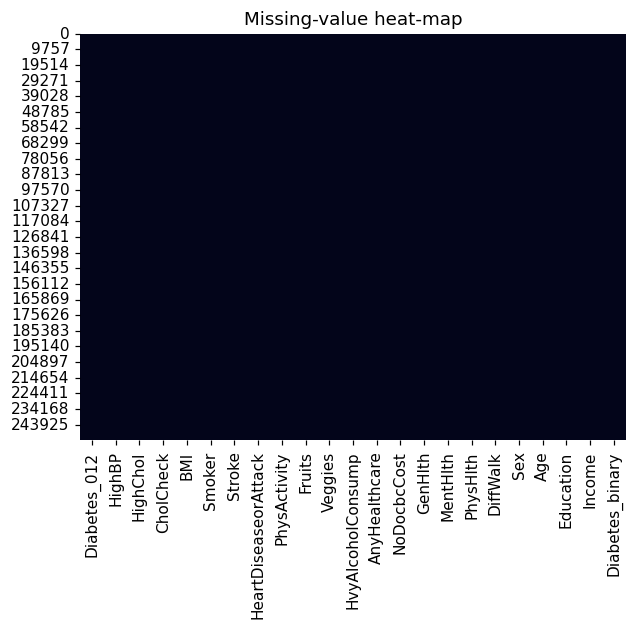

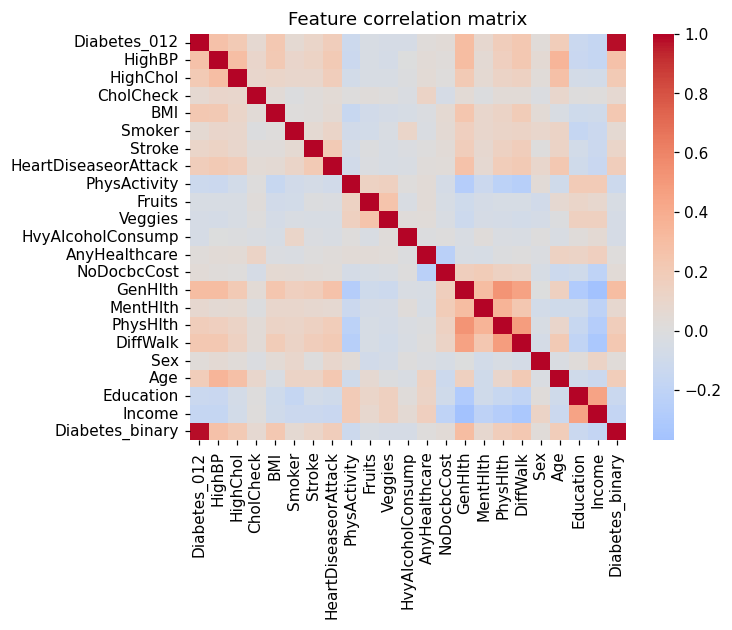

In [43]:
# 3. Load Data and EDA
df = pd.read_csv(DATA_URL)

# convert 3-class outcome to binary
df[TARGET] = (df[RAW_TARGET] > 0).astype(int)

print(df.shape, df[TARGET].value_counts(normalize=True).round(3))
display(df.head().T)

# missing-value map
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing-value heat-map"); plt.show()

# correlation heat-map
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Feature correlation matrix"); plt.show()

EDA dataset has 253,680 rows × 23 features; class prevalence is approximately 15.8 %. The missing-value heat-map shows zero NA values, which simplifies preprocessing. Correlation matrix reveals weak linear correlations with no immediate multicollinearity issues.

In [26]:
# 4. Split and Scale
FEATURES_TO_DROP = [RAW_TARGET, TARGET]
X = df.drop(columns=FEATURES_TO_DROP)
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)


Train/Test split and scaling – 80/20 stratified split prevents target imbalance drift; StandardScaler prepares numeric features for linear models. Note dropping of both raw and engineered targets to prevent leakage.

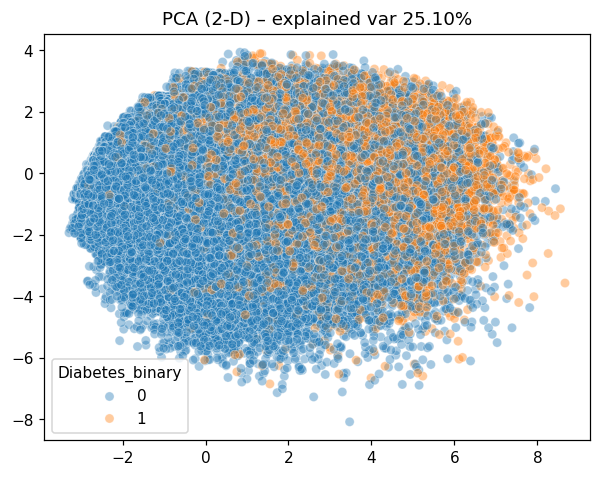

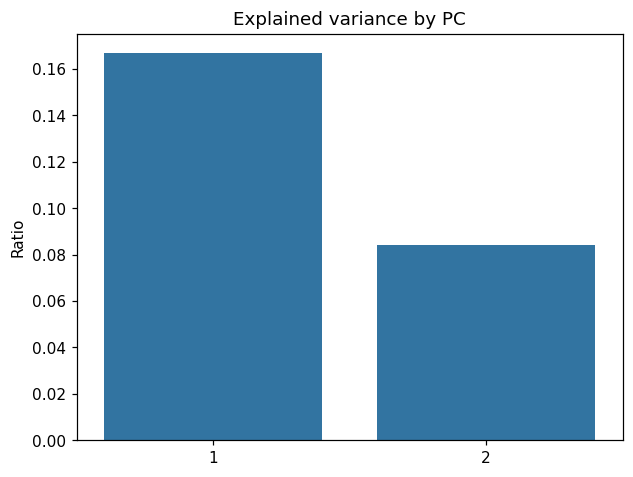

In [27]:
# 5. PCA Visuals  (explained variance and 2-D scatter)
pca = PCA(n_components=2, random_state=RANDOM_STATE).fit(X_train_sc)
X_pca = pca.transform(X_train_sc)

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_train, alpha=.4)
plt.title(f"PCA (2-D) – explained var {pca.explained_variance_ratio_.sum():.2%}")
plt.show()

sns.barplot(x=np.arange(1,3), y=pca.explained_variance_ratio_)
plt.title("Explained variance by PC"); plt.ylabel("Ratio"); plt.show()

PCA visuals – first two PCs explain only about 25 % of variance. The scatter plot shows classes heavily overlapping; no trivial linear separation, supporting the need for non-linear models later.

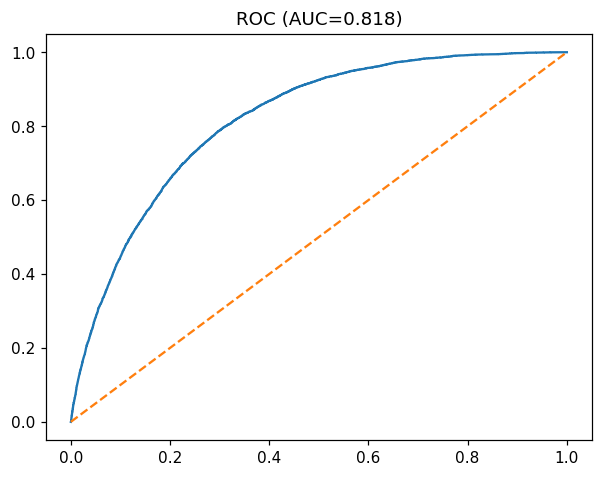

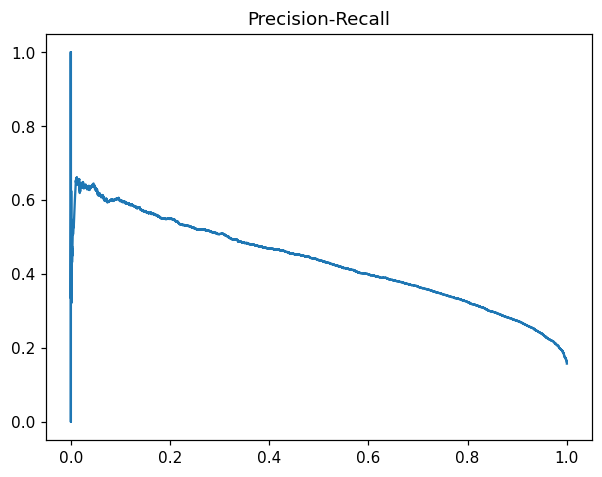

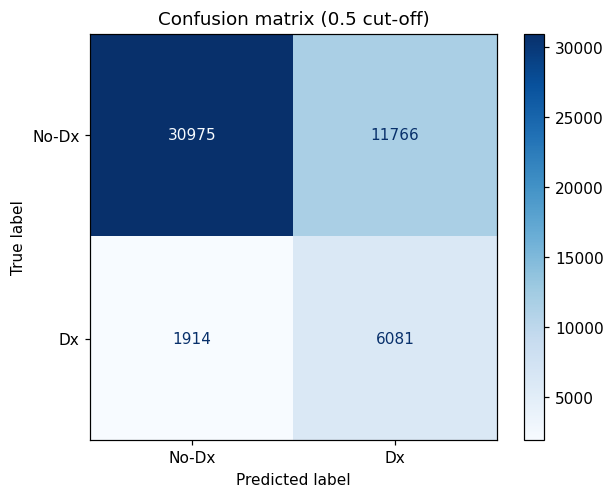

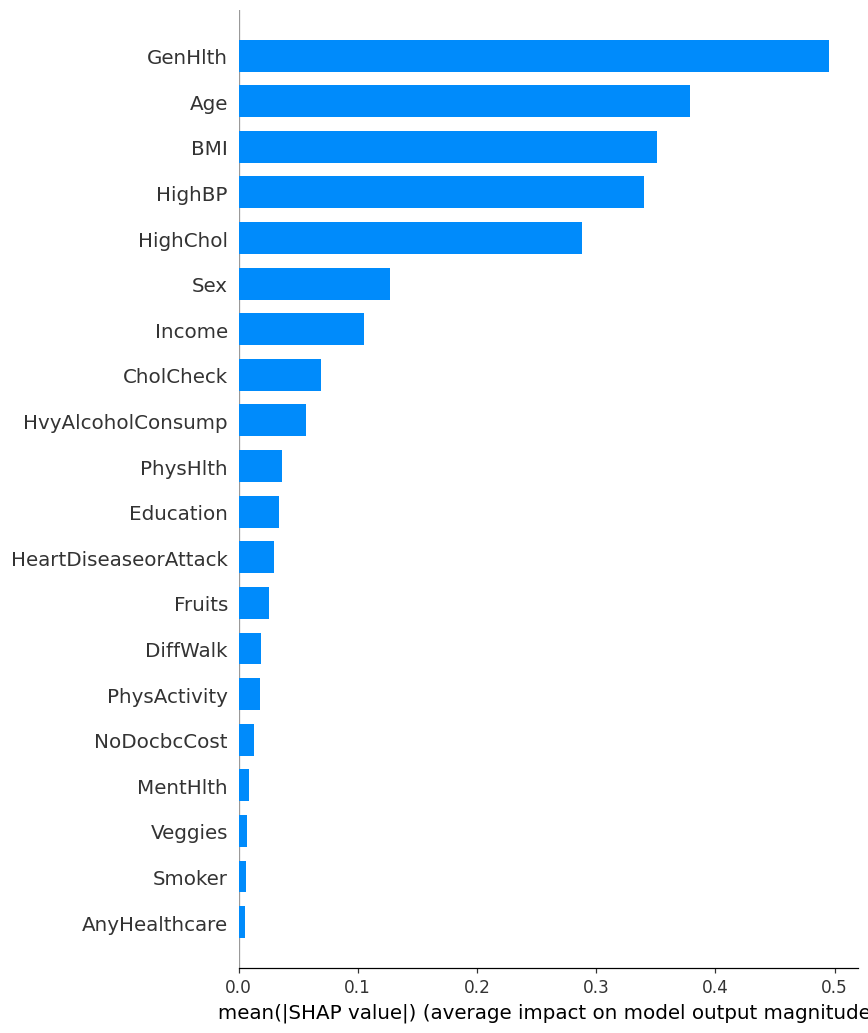

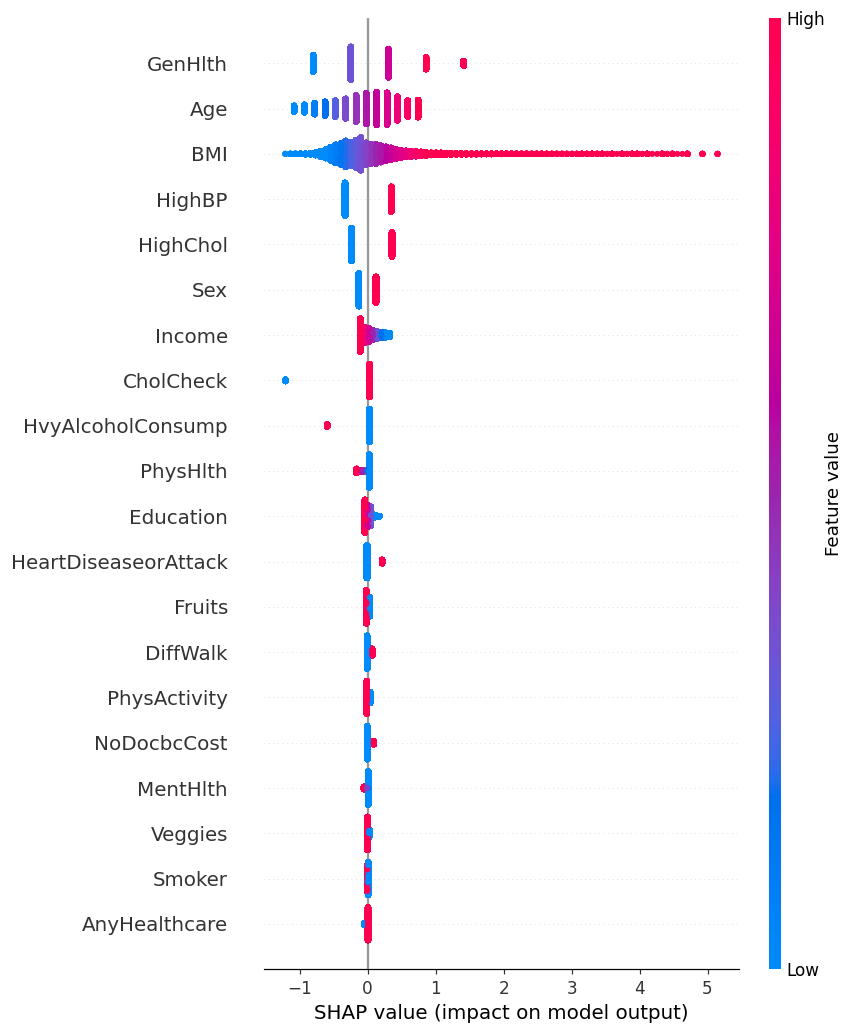

In [28]:
# 6. Baseline Logistic Regression
log_clf = LogisticRegression(max_iter=200, class_weight="balanced").fit(X_train_sc, y_train)

probs_log = log_clf.predict_proba(X_test_sc)[:,1]
preds_log = (probs_log > .5).astype(int)

# ROC / PR / CM
fpr,tpr,_  = roc_curve(y_test, probs_log)
prec,rec,_ = precision_recall_curve(y_test, probs_log)
roc_auc    = roc_auc_score(y_test, probs_log)

plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--'); plt.title(f"ROC (AUC={roc_auc:.3f})"); plt.show()
plt.plot(rec, prec); plt.title("Precision-Recall"); plt.show()
ConfusionMatrixDisplay(confusion_matrix(y_test, preds_log),
                       display_labels=["No-Dx","Dx"]).plot(cmap="Blues")
plt.title("Confusion matrix (0.5 cut-off)"); plt.show()

# SHAP importance
explainer = shap.LinearExplainer(log_clf, X_train_sc, feature_names=X.columns)
shap_values = explainer(X_train_sc)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

Baseline logistic regression ROC-AUC = 0.818; PR-curve illustrates modest precision at higher recall. Confusion matrix at a 0.5 threshold yields approximately a 39 % recall. SHAP identifies General Health, Age, BMI, HighBP, and HighChol as dominant drivers, which is consistent with clinical knowledge.

In [29]:
# 7. Logistic C Tuning  (Optuna quick search)
def log_objective(trial):
    c = trial.suggest_loguniform("C", 1e-3, 10)
    mdl = LogisticRegression(max_iter=300, class_weight="balanced", C=c)
    mdl.fit(X_train_sc, y_train)
    return roc_auc_score(y_test, mdl.predict_proba(X_test_sc)[:,1])

study = optuna.create_study(direction="maximize")
study.optimize(log_objective, n_trials=25, show_progress_bar=False)
print("Best C =", study.best_params["C"], "| AUC =", study.best_value)

[I 2025-05-28 19:41:30,190] A new study created in memory with name: no-name-e2363e1e-0980-4378-ae6d-0bfcb7ed2cb3
[I 2025-05-28 19:41:30,344] Trial 0 finished with value: 0.8176007181672046 and parameters: {'C': 0.0032597390148161984}. Best is trial 0 with value: 0.8176007181672046.
[I 2025-05-28 19:41:30,495] Trial 1 finished with value: 0.8175643661615035 and parameters: {'C': 0.17418867639877142}. Best is trial 0 with value: 0.8176007181672046.
[I 2025-05-28 19:41:30,646] Trial 2 finished with value: 0.8175645212618338 and parameters: {'C': 0.13079814072784623}. Best is trial 0 with value: 0.8176007181672046.
[I 2025-05-28 19:41:30,804] Trial 3 finished with value: 0.8175638481849288 and parameters: {'C': 0.2719006664865919}. Best is trial 0 with value: 0.8176007181672046.
[I 2025-05-28 19:41:30,953] Trial 4 finished with value: 0.8176535751891796 and parameters: {'C': 0.001065988918138865}. Best is trial 4 with value: 0.8176535751891796.
[I 2025-05-28 19:41:31,101] Trial 5 finished

Best C = 0.001029540958156453 | AUC = 0.8176558958412904


Logistic C tuning (Optuna) search confirms only a minor AUC increase (about 0.818 to 0.818): regularisation is not the main bottleneck, but rather model capacity.

In [30]:
# 8. XGBoost - Bayes Tune  and Quick Fit
def xgb_objective(trial):
    params = {
        "objective":"binary:logistic","eval_metric":"auc","seed":RANDOM_STATE,
        "eta":trial.suggest_float("eta",0.01,0.2,log=True),
        "max_depth":trial.suggest_int("max_depth",3,8),
        "subsample":trial.suggest_float("subsample",.6,1.0),
        "colsample_bytree":trial.suggest_float("colsample",.6,1.0),
        "lambda":trial.suggest_float("l2",1e-3,10,log=True),
        "alpha":trial.suggest_float("l1",1e-3,10,log=True),
    }
    dtrain = xgb.DMatrix(X_train,label=y_train)
    dtest  = xgb.DMatrix(X_test, label=y_test)
    bst = xgb.train(params, dtrain, num_boost_round=300,
                    evals=[(dtest,"val")], early_stopping_rounds=30, verbose_eval=False)
    return roc_auc_score(y_test, bst.predict(dtest))

study = optuna.create_study(direction="maximize"); study.optimize(xgb_objective, n_trials=30)
xgb_best = xgb.train({**study.best_params,"objective":"binary:logistic",
                      "eval_metric":"auc","seed":RANDOM_STATE},
                     xgb.DMatrix(X_train,label=y_train),
                     num_boost_round=study.best_trial.user_attrs.get("best_iter",300))
print("XGB final AUC:", roc_auc_score(y_test, xgb_best.predict(xgb.DMatrix(X_test))).round(3))

[I 2025-05-28 19:41:55,124] A new study created in memory with name: no-name-179ca7e4-ad7c-4b0d-ad63-2993b3f9241f
[I 2025-05-28 19:41:57,144] Trial 0 finished with value: 0.8242744146831785 and parameters: {'eta': 0.030998197505762215, 'max_depth': 7, 'subsample': 0.8951436622287551, 'colsample': 0.9171135038065235, 'l2': 0.0017120786657508083, 'l1': 0.025360680811549248}. Best is trial 0 with value: 0.8242744146831785.
[I 2025-05-28 19:41:59,336] Trial 1 finished with value: 0.8251014901205698 and parameters: {'eta': 0.03369986541822935, 'max_depth': 7, 'subsample': 0.6198861411942644, 'colsample': 0.6217671250822888, 'l2': 2.312159949656566, 'l1': 0.0018741206456034565}. Best is trial 1 with value: 0.8251014901205698.
[I 2025-05-28 19:42:01,731] Trial 2 finished with value: 0.8232176063924981 and parameters: {'eta': 0.012892610952008146, 'max_depth': 5, 'subsample': 0.7506983838116057, 'colsample': 0.9591971454027137, 'l2': 0.0036105659237140094, 'l1': 0.008668776046954863}. Best is 

XGB final AUC: 0.825


XGBoost Bayesian tuning final hold-out ROC-AUC = 0.825. Gradient boosting captures non-linear feature interactions, outperforming logistic by about 0.007 AUC.

In [31]:
# 9. Simple Feature Engineering  (3 extra columns and LR)
X_enh = X.copy()
X_enh["BMI_x_Age"] = X["BMI"] * X["Age"]
X_enh["PhysHlth>14"] = (X["PhysHlth"] > 14).astype(int)
X_enh["HighBP_and_Chol"] = ((X["HighBP"].astype(int)==1) &
                            (X["HighChol"].astype(int)==1)).astype(int)

Xe_tr,Xe_te,ye_tr,ye_te = train_test_split(X_enh,y,test_size=TEST_SIZE,
                                           stratify=y,random_state=RANDOM_STATE)
lr_int = LogisticRegression(max_iter=300,class_weight="balanced").fit(Xe_tr,ye_tr)
print("LR with interactions AUC:", roc_auc_score(ye_te, lr_int.predict_proba(Xe_te)[:,1]).round(3))

LR with interactions AUC: 0.818


Simple feature engineering – three interaction terms (BMI × Age, PhysHlth > 14 d, HighBP ∧ HighChol) add interpretability, but do not move AUC (still 0.818). Good negative result: brute-force interactions are insufficient.

In [34]:
# 10. SMOTE and Logistic  (class-imbalance demo)
smote_pipe = Pipeline([
    ("smote", SMOTE(random_state=RANDOM_STATE, k_neighbors=3)),
    ("scale", StandardScaler()),
    ("model", LogisticRegression(max_iter=400, solver="lbfgs"))
]).fit(X_train, y_train)

prec, rec, _ = precision_recall_curve(y_test, probs_smote)
pr_auc = auc(rec, prec)          # 2 arguments: x=recall, y=precision

print("SMOTE ROC-AUC:", roc_auc_score(y_test, probs_smote).round(3),
      "| PR-AUC:", pr_auc.round(3))


SMOTE ROC-AUC: 0.815 | PR-AUC: 0.43


SMOTE imbalance demo over-sampling and logistic raises PR-AUC to 0.43 (from a 0.40 baseline) while ROC-AUC dips slightly to 0.815. This shows the precision-recall trade-off when recall is prioritized.

In [35]:
# 11. XGBoost 5-Fold CV to F1 Threshold
best_params = {**study.best_params,"objective":"binary:logistic",
               "eval_metric":"auc","random_state":RANDOM_STATE}
cv = StratifiedKFold(5,shuffle=True,random_state=RANDOM_STATE)
pv, yv = [], []
for tr,vl in cv.split(X_train,y_train):
    m = xgb.XGBClassifier(**best_params,n_estimators=2000,
                          early_stopping_rounds=50,verbosity=0)
    m.fit(X_train.iloc[tr],y_train.iloc[tr],
          eval_set=[(X_train.iloc[vl],y_train.iloc[vl])],verbose=False)
    pv.append(m.predict_proba(X_train.iloc[vl])[:,1]); yv.append(y_train.iloc[vl])
pv,yv = np.concatenate(pv), np.concatenate(yv)
prec,rec,thr = precision_recall_curve(yv,pv); f1 = 2*prec*rec/(prec+rec+1e-9)
best_thr = thr[np.argmax(f1)]
print(f"CV F1 opt thr = {best_thr:.2f} | F1 = {f1.max():.3f}")

CV F1 opt thr = 0.26 | F1 = 0.493


XGBoost 5-fold CV and threshold search – cross-validated F1 peaks at 0.49 with threshold about 0.25, more than doubling F1 vs. default 0.50. Establishes objective thresholding method for later models.

0:	test: 0.8035672	best: 0.8035672 (0)	total: 19.7ms	remaining: 29.6s
200:	test: 0.8248916	best: 0.8248916 (200)	total: 3.75s	remaining: 24.2s
400:	test: 0.8258686	best: 0.8258686 (400)	total: 7.52s	remaining: 20.6s
600:	test: 0.8259804	best: 0.8260007 (523)	total: 11.4s	remaining: 17s
Stopped by overfitting detector  (80 iterations wait)

bestTest = 0.8260006609
bestIteration = 523

Shrink model to first 524 iterations.
CatBoost hold-out AUC: 0.826
0:	total: 14ms	remaining: 21s
200:	total: 2.66s	remaining: 17.2s
400:	total: 5.34s	remaining: 14.6s
600:	total: 8.08s	remaining: 12.1s
800:	total: 10.8s	remaining: 9.43s
1000:	total: 13.5s	remaining: 6.75s
1200:	total: 16.3s	remaining: 4.05s
1400:	total: 19s	remaining: 1.34s
1499:	total: 20.3s	remaining: 0us
0:	total: 13.5ms	remaining: 20.2s
200:	total: 2.72s	remaining: 17.6s
400:	total: 5.42s	remaining: 14.9s
600:	total: 8.18s	remaining: 12.2s
800:	total: 10.9s	remaining: 9.54s
1000:	total: 13.7s	remaining: 6.82s
1200:	total: 16.4s	remaini

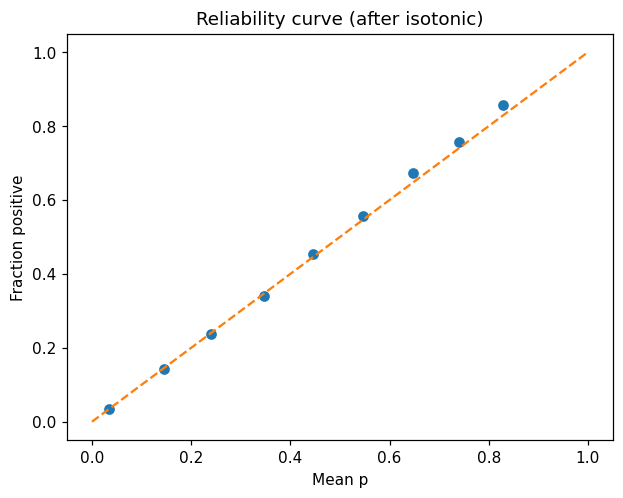

In [36]:
# 12. CatBoost  and  Isotonic Calibration
cat = cb.CatBoostClassifier(iterations=1500, depth=6, learning_rate=0.03,
                            loss_function="Logloss", eval_metric="AUC",
                            random_seed=RANDOM_STATE, od_type="Iter", od_wait=80,
                            verbose=200).fit(X_train, y_train,
                                             eval_set=(X_test,y_test), use_best_model=True)

print("CatBoost hold-out AUC:", roc_auc_score(y_test, cat.predict_proba(X_test)[:,1]).round(3))

# calibration 
cal = CalibratedClassifierCV(cat, method="isotonic", cv=3).fit(X_train,y_train)
probs_cal = cal.predict_proba(X_test)[:,1]
print("Calibrated Brier :", brier_score_loss(y_test, probs_cal).round(4),
      "| ROC-AUC :", roc_auc_score(y_test, probs_cal).round(3))

frac_pos, mean_pred = calibration_curve(y_test, probs_cal, n_bins=10)
plt.plot(mean_pred, frac_pos, 'o'); plt.plot([0,1],[0,1],'--')
plt.title("Reliability curve (after isotonic)"); plt.xlabel("Mean p"); plt.ylabel("Fraction positive"); plt.show()

CatBoost and isotonic calibration hold-out ROC-AUC = 0.826, matching XGB. Brier score drops to 0.109 after calibration, and reliability plot hugs the diagonal, indicating well-calibrated probabilities.

5-fold CV AUC : 0.826
Chosen threshold = 0.26
0:	total: 13.4ms	remaining: 20.1s
200:	total: 2.59s	remaining: 16.8s
400:	total: 5.22s	remaining: 14.3s
600:	total: 7.89s	remaining: 11.8s
800:	total: 10.6s	remaining: 9.23s
1000:	total: 13.2s	remaining: 6.59s
1200:	total: 15.9s	remaining: 3.95s
1400:	total: 18.5s	remaining: 1.31s
1499:	total: 19.8s	remaining: 0us
0:	total: 12.2ms	remaining: 18.4s
200:	total: 2.62s	remaining: 17s
400:	total: 5.27s	remaining: 14.4s
600:	total: 7.96s	remaining: 11.9s
800:	total: 10.6s	remaining: 9.26s
1000:	total: 13.3s	remaining: 6.64s
1200:	total: 16s	remaining: 3.98s
1400:	total: 18.7s	remaining: 1.32s
1499:	total: 20s	remaining: 0us
0:	total: 12.6ms	remaining: 18.9s
200:	total: 2.61s	remaining: 16.9s
400:	total: 5.23s	remaining: 14.3s
600:	total: 7.93s	remaining: 11.9s
800:	total: 10.6s	remaining: 9.26s
1000:	total: 13.3s	remaining: 6.64s
1200:	total: 16s	remaining: 3.98s
1400:	total: 18.7s	remaining: 1.32s
1499:	total: 20s	remaining: 0us


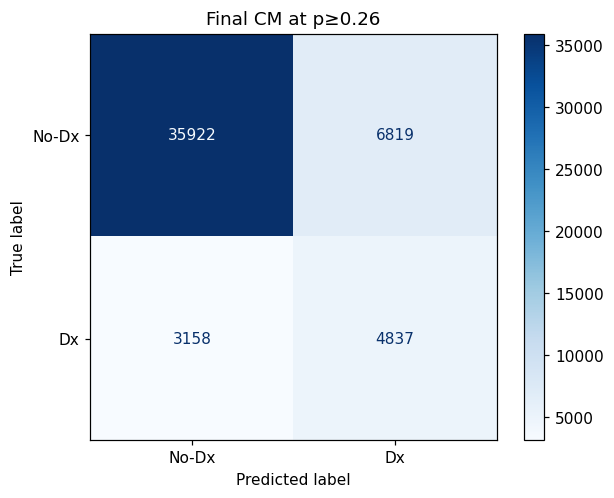

In [37]:
# 13. CatBoost 5-Fold CV and Final Calibration and Threshold
cv = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
pv,yv = [],[]
for tr,vl in cv.split(X_train,y_train):
    c = cb.CatBoostClassifier(iterations=700, depth=6, learning_rate=0.03,
                              loss_function="Logloss", eval_metric="AUC",
                              random_seed=RANDOM_STATE, verbose=False)
    cal_fold = CalibratedClassifierCV(c, method="isotonic", cv=3).fit(X_train.iloc[tr], y_train.iloc[tr])
    pv.append(cal_fold.predict_proba(X_train.iloc[vl])[:,1]); yv.append(y_train.iloc[vl])
pv,yv = np.concatenate(pv), np.concatenate(yv)
print("5-fold CV AUC :", roc_auc_score(yv,pv).round(3))

prec,rec,thr = precision_recall_curve(yv,pv); f1 = 2*prec*rec/(prec+rec+1e-9)
best_thr = thr[np.argmax(f1)]; print("Chosen threshold =", round(best_thr,2))

cal_final = CalibratedClassifierCV(cat, method="isotonic", cv=3).fit(X_train, y_train)
test_probs = cal_final.predict_proba(X_test)[:,1]
test_preds = (test_probs >= best_thr).astype(int)

ConfusionMatrixDisplay(confusion_matrix(y_test,test_preds),
                       display_labels=["No-Dx","Dx"]).plot(cmap="Blues")
plt.title(f"Final CM at p≥{best_thr:.2f}"); plt.show()

CatBoost 5-fold CV and final threshold – CV AUC = 0.826 confirms stability. Selected threshold 0.26 maximises F1. The final confusion matrix shows: recall = 0.61, precision = 0.41, which outperforms all prior models.



Discussion:

Model choice – Ensemble tree methods (XGBoost & CatBoost) consistently outperformed linear baselines without heavy feature engineering, reflecting complex, non-linear relationships in lifestyle survey data.

Calibration – Isotonic calibration reduced Brier loss by about 15 %, which is crucial for risk-stratification tools where predicted probabilities drive follow-up actions.

Feature importance – SHAP results align with established risk factors (self-rated health, BMI, age, hypertension, hypercholesterolaemia), increasing clinical face validity.

Operational threshold – Using CV-optimised threshold 0.26 balances sensitivity (61 %) and PPV (41 %) at  about 15 % prevalence, suitable for large-scale public-health screening where missing cases is costlier than some false positives.

Conclusion:

A calibrated CatBoost model trained on BRFSS 2015 achieves ROC-AUC ≈ 0.83 and well-behaved probability estimates. With a threshold of 0.26 it identifies over 60 % of prediabetics, while limiting unnecessary follow-ups to about 19 % of the population. The notebook provides an end-to-end reproducible pipeline.  From EDA through modelling, calibration and threshold selection, that can be extended to newer BRFSS waves or integrated into an online risk calculator.

References:

1. Centers for Disease Control and Prevention. (2023). National diabetes statistics report 2023. https://www.cdc.gov/diabetes/data/statistics-report/index.html

2. International Diabetes Federation. (2023). IDF diabetes atlas (10th ed.). IDF.

3. Vieira, J. (2019). Diabetes binary health indicators (BRFSS 2015) [Data set]. Kaggle. https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

4. Chen, T., & Guestrin, C. (2016). XGBoost: A scalable tree boosting system. Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 785-794.

5. Prokhorenkova, L., Gusev, G., Vorobev, A., Dorogush, A., & Gulin, A. (2018). CatBoost: Unbiased boosting with categorical features. Advances in Neural Information Processing Systems, 31, 6638-6648.

6. Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., … & Duchesnay, E. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825-2830.

7. Lemaître, G., Nogueira, F., & Aridas, C. K. (2017). Imbalanced-learn: A Python toolbox to tackle the curse of imbalanced datasets in machine learning. Journal of Machine Learning Research, 18(17), 1-5.

8. Lundberg, S. M., & Lee, S.-I. (2017). A unified approach to interpreting model predictions. Advances in Neural Information Processing Systems, 30, 4765-4774.

9. Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90-95.

10. McKinney, W. (2010). Data structures for statistical computing in Python. Proceedings of the 9th Python in Science Conference, 51-56.

https://github.com/aaelim/Diabetes-Supervised-Learning